<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/INF0618_Trabalho_01_Kurosawa_Suda_Wakabayashi_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inf0618 Deep Learning - Trabalho 1 - CNN**
## Integrantes do grupo:
#### - Daniel Noriaki Kurosawa
#### - Eric Uyemura Suda
#### - Fernando Shigeru Wakabayashi

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 30 19:34:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Importando as libs necessarias


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Flatten, Dropout,
    GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, MaxPool2D
)

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.metrics import (
    confusion_matrix, classification_report,
    balanced_accuracy_score
)
np.set_printoptions(precision=4,suppress=True)

%matplotlib inline

In [4]:
# Funcoes auxiliares

def fit_train_eval(model, x_train, y_train, epochs, batch_size, class_weight, validation_data, callback_list):
  print("Treinando o Modelo \n\n")
  history = model.fit(x_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      class_weight=class_weight,
                      validation_data=validation_data,
                      use_multiprocessing=True,
                      callbacks = callback_list)
  
  # Faz as predições para o conjunto de teste
  print("\nFazendo Predicoes da Validacao\n")
  predictions = model.predict(x_val)
  #score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.

  #Matriz de confusão
  cm = confusion_matrix(np.argmax(predictions, axis=1), validation_data[1])

  plt.figure(figsize = (11,9))
  ax1=plt.axes()
  ax1.set_title("Matriz de Confusao")
  sns.set(font_scale=0.9)
  sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')

  # Matriz de confusão normalizada
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cmn) / num_classes
  print("\n\nAcurácia balanceada:", balanced_acc, "\n")

  plt.figure(figsize = (11,9))
  ax = plt.axes()
  ax.set_title("Matriz de Confusao Normalizada")
  sns.set(font_scale=0.9)
  sns.heatmap(cmn, annot=True, fmt='.1%', cmap='viridis')

  #COLOCAR PLOTS DOS TREINOS

  #COLOCAR ROC E AUC

  # Curva de Vies Varianca
  return history

In [5]:
#Importando Dataset do trabalho

from tensorflow.keras.datasets import cifar10
(x_trainval, y_trainval), (x_test, y_test) = cifar10.load_data()

In [6]:
#Cada imagem tem o tamanho de 32x32x3

print("Tamanho treino {}".format(x_trainval.shape), "\t", "Tamanho teste {}".format(x_test.shape))

Tamanho treino (50000, 32, 32, 3) 	 Tamanho teste (10000, 32, 32, 3)


In [7]:
#Dataset ja esta balanceado com 5k amostras para cada classe de imagem

unique, counts = np.unique(y_trainval, return_counts=True)
print("Treino ---> ", dict(zip(unique, counts)), "\n")

Treino --->  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000} 



## 1) Separando Dataset em Treino e Validacao (0,5)

Separe 20% dos dados de treinamento para validação. Todos os treinamentos intermediários devem ser avaliados neste conjunto de validação.



In [8]:
#Embaralha os dados e divide em 80% para treino, 20% para validação
nData = x_trainval.shape[0]  
nTrain = int(nData * 0.8)  
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

#Divide os dados
x_val, y_val = x_trainval[valIdx], y_trainval[valIdx]
x_train, y_train = x_trainval[trainIdx], y_trainval[trainIdx]

print("Formato das imagens de treinamento", x_train.shape)
print("Formato dos rótulos de treinamento", y_train.shape)
print()

print("Formato das imagens de validação", x_val.shape)
print("Formato dos rótulos de validação", y_val.shape)

Formato das imagens de treinamento (40000, 32, 32, 3)
Formato dos rótulos de treinamento (40000, 1)

Formato das imagens de validação (10000, 32, 32, 3)
Formato dos rótulos de validação (10000, 1)


Escalando dados de para um intervalo de 0-1

In [9]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

Pré Processando Saídas

In [10]:
#Para utilizar SparceCategoricalCrossentropy
y_train_f,  y_val_f, y_test_f = y_train.flatten(), y_val.flatten(), y_test.flatten()
#teste de sanidade
pd.Series(y_train_f).value_counts().sort_index()

0    3990
1    3979
2    4046
3    4033
4    3983
5    3946
6    3999
7    4026
8    3989
9    4009
dtype: int64

In [11]:
# One hot encoding das classes de saida
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)
print("Exemplo: ")
print("Classe Imagem: ", y_train[0], "\tOne Hot: ", y_train_oh[0])

(40000, 32, 32, 3) (40000, 10)
Exemplo: 
Classe Imagem:  [4] 	One Hot:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [12]:
num_classes

10

# 2) Criando Rede Neural Baseline (1,0)

Construa uma rede neural convolucional para baseline. Sugestão: comece por uma arquitetura simples. Quanto mais simples, melhor.

Função para printar Confusion matrix e gráficos de Loss e Acc

In [13]:
def print_evaluate(model, model_history , x_val, y_val_model, model_filepath):
    print("\nFazendo Predicoes da Validacao\n")
    model.load_weights(model_filepath)
    predictions = model.predict(x_val)
    #score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.
    
    #Matriz de confusão
    cm = confusion_matrix(np.argmax(predictions, axis=1), y_val)


    cm_b = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
    balanced_acc = np.trace(cm_b) / num_classes
    print("\n\nAcurácia balanceada:", balanced_acc, "\n")

    fig, axs = plt.subplots(2, 2, figsize = (16,12), gridspec_kw={'height_ratios': [2, 1]})

    #ax[0,0]
    sns.heatmap(ax = axs[0, 0], data = cm, fmt='g', annot = True)
    axs[0, 0].set_title('Matriz de Confusao')
    #ax[0,1]
    sns.heatmap(ax = axs[0, 1], data =cm_b, fmt='.1%', annot = True)
    axs[0, 1].set_title('Matriz de Confusao Normalizada')

    #ax[1,0]
    axs[1, 0].set_title('Loss')
    axs[1, 0].plot(model_history.history['loss'], label='loss')
    axs[1, 0].plot(model_history.history['val_loss'], label='val_loss')
    axs[1, 0].legend()

    axs[1, 1].set_title('accuracy')
    axs[1, 1].plot(model_history.history['accuracy'], label='acc')
    axs[1, 1].plot(model_history.history['val_accuracy'], label='val_acc')
    axs[1, 1].legend()  


### 2.1) Teste com CategoricalCrossentropy

In [14]:
# Rede Neural Vanilla
model_baseline = Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(Flatten())
#Densa com 10 nós de saída
model_baseline.add(Dense(10,activation='softmax'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [15]:
filepath="model_baseline_hist.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#.fit(x_train,y_cat_train,epochs=15,validation_data=(x_test,y_cat_test),callbacks=[early_stop])
model_baseline_hist = model_baseline.fit(x_train, y_train_oh,
                                         epochs = 64, batch_size = 32,                                        
                                         validation_data=(x_val, y_val_oh),
                                         callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8272 - accuracy: 0.3611 - val_loss: 1.7212 - val_accuracy: 0.4053

Epoch 00001: val_accuracy improved from -inf to 0.40530, saving model to model_baseline_hist.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6935 - accuracy: 0.4114 - val_loss: 1.7278 - val_accuracy: 0.3998

Epoch 00002: val_accuracy did not improve from 0.40530
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6788 - accuracy: 0.4150 - val_loss: 1.6986 - val_accuracy: 0.4008

Epoch 00003: val_accuracy did not improve from 0.40530
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6606 - accuracy: 0.4228 - val_loss: 1.6607 - val_accuracy: 0.4190

Epoch 00004: val_accuracy improved from 0.40530 to 0.41900, saving model to model_baseline_hist.h5
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6490 - accuracy: 0.4290 - val_loss: 1


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.43094907293279466 



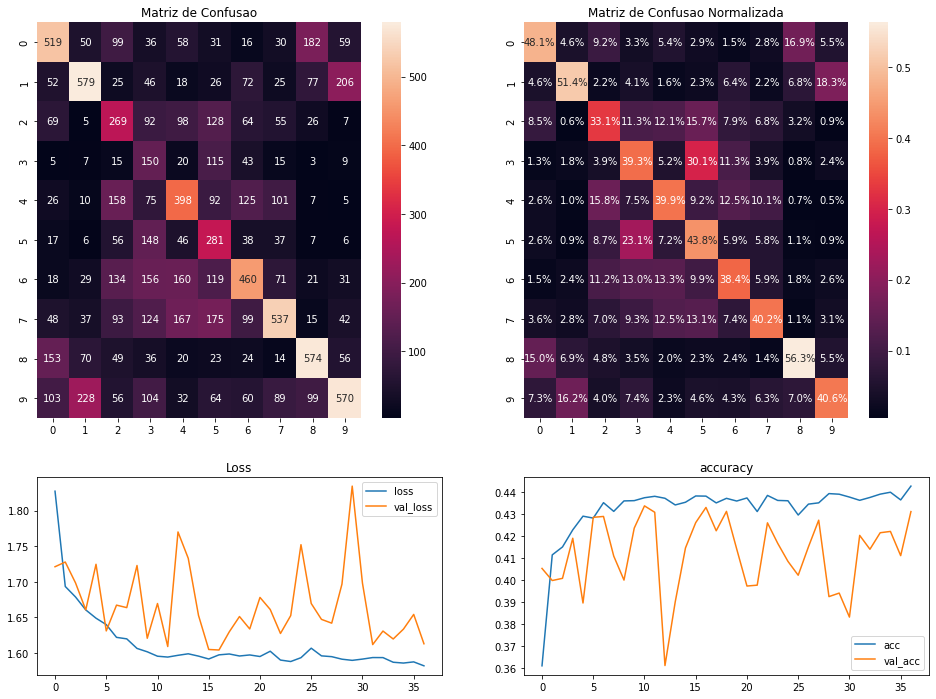

In [16]:
print_evaluate(model_baseline,model_baseline_hist, x_val, y_val_oh,"model_baseline_hist.h5" )

### 2.2 ) Teste com SparseCategoricalCrossentropy

In [17]:
# Rede Neural Vanilla

model_baseline = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(Flatten())
#Densa com 10 nós de saída
model_baseline.add(Dense(10 ,activation = 'softmax'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [18]:
filepath="model_baseline_hist_cce.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model_baseline_hist = model_baseline.fit(x_train, y_train_f,
                                         epochs = 64, batch_size = 32,                                        
                                         validation_data=(x_val, y_val_f),
                                         callbacks=[early_stop, checkpoint] )


Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7840 - accuracy: 0.3755 - val_loss: 1.6576 - val_accuracy: 0.4179

Epoch 00001: val_accuracy improved from -inf to 0.41790, saving model to model_baseline_hist_cce.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6133 - accuracy: 0.4365 - val_loss: 1.5819 - val_accuracy: 0.4538

Epoch 00002: val_accuracy improved from 0.41790 to 0.45380, saving model to model_baseline_hist_cce.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5798 - accuracy: 0.4498 - val_loss: 1.5473 - val_accuracy: 0.4659

Epoch 00003: val_accuracy improved from 0.45380 to 0.46590, saving model to model_baseline_hist_cce.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5684 - accuracy: 0.4543 - val_loss: 1.6858 - val_accuracy: 0.4012

Epoch 00004: val_accuracy did not improve from 0.46590
Epoch 5/64
1250/1250 [==============================] - 3s 


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.49358180454333767 



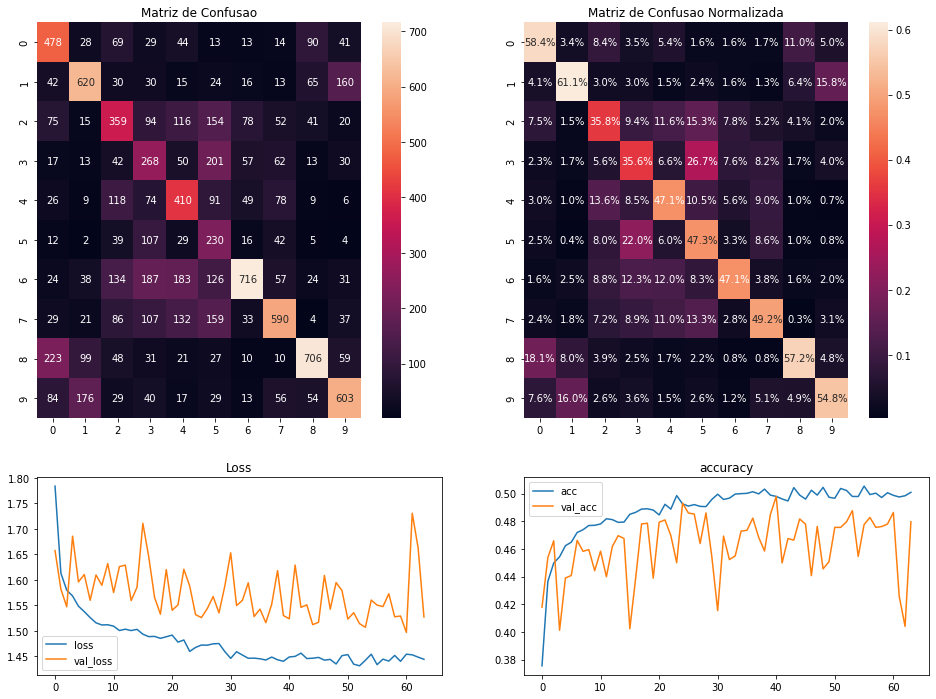

In [19]:
print_evaluate(model_baseline,model_baseline_hist, x_val, y_val_f, 'model_baseline_hist_cce.h5')

Observando a acurácia decidimos por utilizar a SparseCategoricalCrossentropy(), a Loss do Sparce aparenta começo de overfitting, aumentanto / se mantendo estável enquanto a loss de treino diminui, porém ele apresenta melhor acc na acurácia, outro ponto de vista é que no gráfico de  não da pra verificar regiões de overffiting 

## 3) Testando Diferentes Funcoes de Ativacao Para o Mesmo Modelo Baseline (0,5)

[Referencia de Funcoes de Ativacao](https://keras.io/api/layers/activations/)

 Explore o impacto de três diferentes funções de ativação.


In [20]:
def ret_model_vanila(activation:str = 'relu')->Sequential:
  model = Sequential()
  #Camada convolucional com 32 filtros de tamanho 3x3 
  model.add(Conv2D(32, 3, padding='same', activation=activation, input_shape=(32, 32, 3)))
  #Max pooling de tamanho 2x2
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Operação de vetorização dos dados
  model.add(Flatten())
  #Densa com 10 nós de saída
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  model.summary()
  return model



3.1 - Sigmoid

In [21]:
# Modelo Vanilla com Funcao de Ativacao Sigmoide
model_baseline_sig =ret_model_vanila(activation='sigmoid')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [22]:
filepath="model_baseline_sig.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_sig = model_baseline_sig.fit(x_train, y_train_f,
                                            epochs = 64, batch_size = 32,                                        
                                            validation_data=(x_val, y_val_f),
                                            callbacks=[early_stop, checkpoint] )


Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.7011 - accuracy: 0.2714 - val_loss: 1.9047 - val_accuracy: 0.3383

Epoch 00001: val_accuracy improved from -inf to 0.33830, saving model to model_baseline_sig.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7930 - accuracy: 0.3793 - val_loss: 1.6799 - val_accuracy: 0.4131

Epoch 00002: val_accuracy improved from 0.33830 to 0.41310, saving model to model_baseline_sig.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5890 - accuracy: 0.4424 - val_loss: 1.5550 - val_accuracy: 0.4571

Epoch 00003: val_accuracy improved from 0.41310 to 0.45710, saving model to model_baseline_sig.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4810 - accuracy: 0.4824 - val_loss: 1.4403 - val_accuracy: 0.5062

Epoch 00004: val_accuracy improved from 0.45710 to 0.50620, saving model to model_baseline_sig.h5
Epoch 5/64
1250/1250 [=========


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.562169740029951 



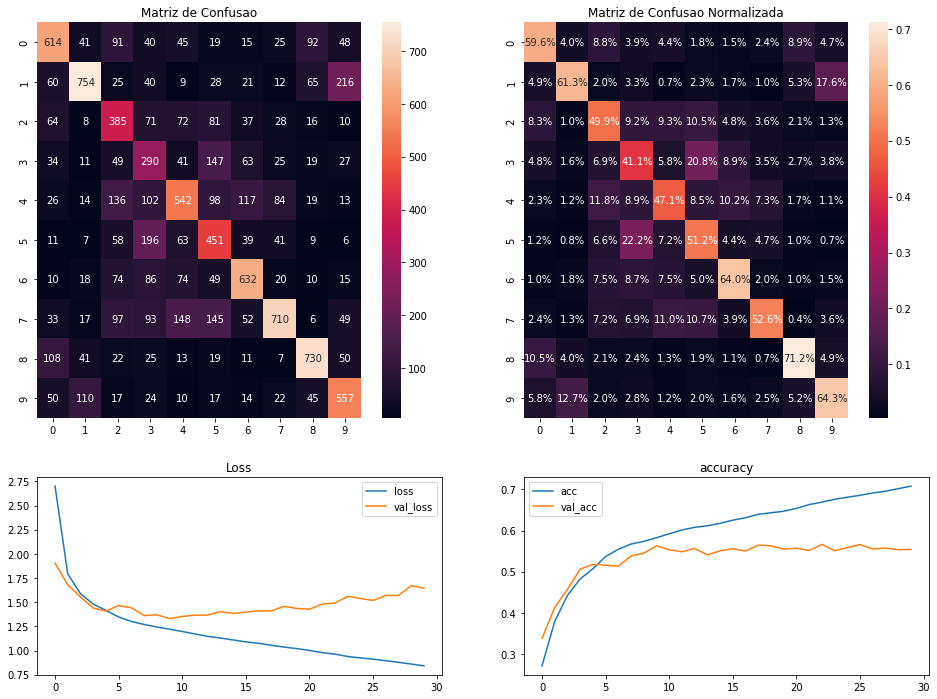

In [23]:
print_evaluate(model_baseline_sig, history_model_baseline_sig, x_val, y_val_f, 'model_baseline_sig.h5')

3.2 - Tangente Hiperbólica

In [24]:
# Modelo Vanilla com Funcao de Ativacao Tangente Hiperbolica
model_baseline_tan = ret_model_vanila(activation='tanh')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [25]:
filepath="model_tan.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_tan = model_baseline_tan.fit(x_train, y_train_f,
                                                    epochs = 64, batch_size = 32,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0163 - accuracy: 0.3813 - val_loss: 2.3037 - val_accuracy: 0.3737

Epoch 00001: val_accuracy improved from -inf to 0.37370, saving model to model_tan.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8060 - accuracy: 0.4603 - val_loss: 2.5489 - val_accuracy: 0.3607

Epoch 00002: val_accuracy did not improve from 0.37370
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8330 - accuracy: 0.4837 - val_loss: 2.0028 - val_accuracy: 0.4499

Epoch 00003: val_accuracy improved from 0.37370 to 0.44990, saving model to model_tan.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7848 - accuracy: 0.5056 - val_loss: 2.2774 - val_accuracy: 0.4536

Epoch 00004: val_accuracy improved from 0.44990 to 0.45360, saving model to model_tan.h5
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7131 - accuracy: 0.5238


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5248463040344618 



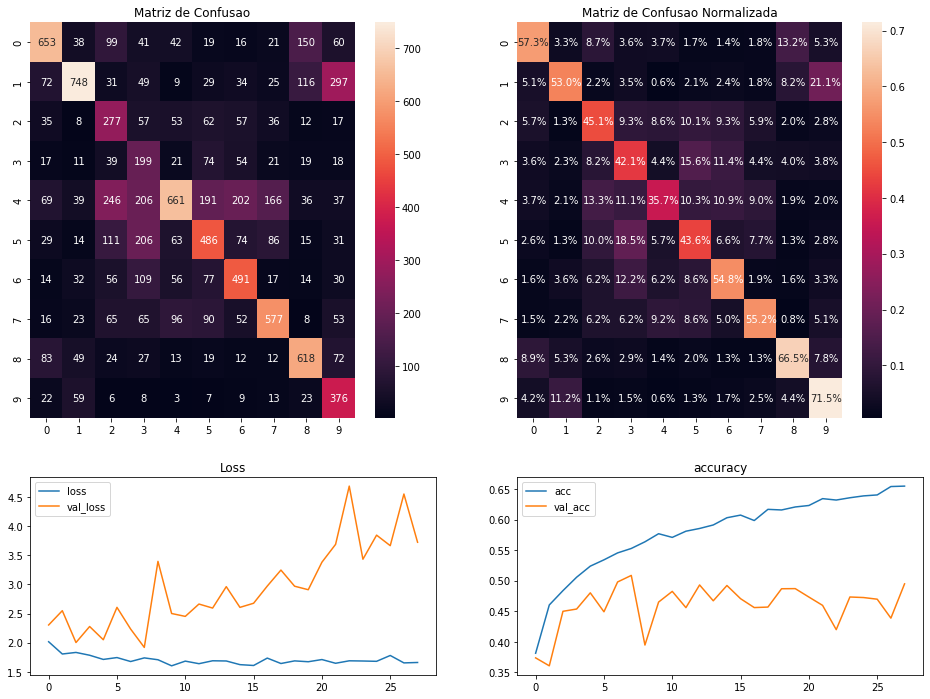

In [26]:
print_evaluate(model_baseline_tan,history_model_baseline_tan, x_val, y_val_f, 'model_tan.h5')

### 3.3 - selu

In [27]:
# Modelo Vanilla com Funcao de Ativacao SeLu

model_baseline_selu = ret_model_vanila(activation='selu')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [28]:
filepath="model_selu.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_selu= model_baseline_selu.fit(x_train, y_train_f,
                                                    epochs = 64, batch_size = 32,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 3.4481 - accuracy: 0.3649 - val_loss: 1.5916 - val_accuracy: 0.4696

Epoch 00001: val_accuracy improved from -inf to 0.46960, saving model to model_selu.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5263 - accuracy: 0.4963 - val_loss: 1.9865 - val_accuracy: 0.4274

Epoch 00002: val_accuracy did not improve from 0.46960
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9492 - accuracy: 0.4614 - val_loss: 2.2057 - val_accuracy: 0.4301

Epoch 00003: val_accuracy did not improve from 0.46960
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 3.7988 - accuracy: 0.4957 - val_loss: 1.6753 - val_accuracy: 0.4995

Epoch 00004: val_accuracy improved from 0.46960 to 0.49950, saving model to model_selu.h5
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4623 - accuracy: 0.5493 - val_loss: 2.0766 - val_accura


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5231501062454152 



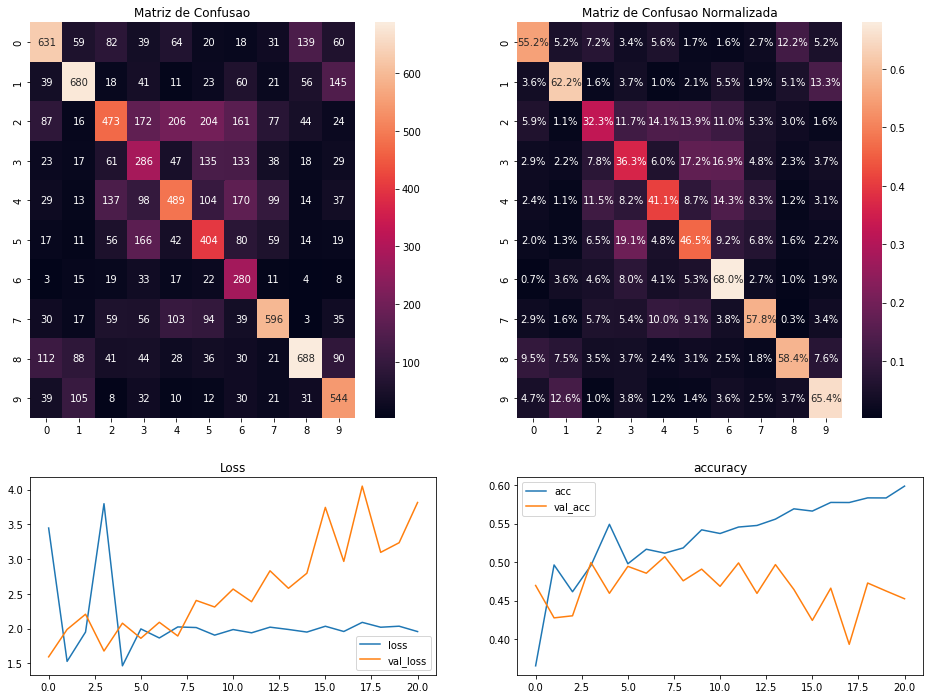

In [29]:
print_evaluate(model_baseline_selu,history_model_baseline_selu, x_val, y_val_f, 'model_selu.h5')

## 4) Variacao da quantidade de camadas de convolucao e pooling (2,5) 

Explore o impacto de variar a quantidade de camadas de convolução e pooling. Cuidado com overfitting! Explore, no mínimo, duas arquiteturas diferentes do baseline.

4.1 - Primeira rede


In [30]:
# Rede Neural com mais camadas de convolucao e pooling

model_conv_p_01 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_conv_p_01.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_conv_p_01.add(MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_conv_p_01.add(Conv2D(64, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_conv_p_01.add(MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_conv_p_01.add(Flatten())

# FC
model_conv_p_01.add(Dense(1028, activation='relu'))

#Densa com 10 nós de saída
model_conv_p_01.add(Dense(10, activation='softmax'))

model_conv_p_01.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

model_conv_p_01.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1028)              4211716   
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [31]:
filepath="model_conv_p_01.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_conv_p_01= model_conv_p_01.fit(x_train, y_train_f,
                                                    epochs = 64, batch_size = 32,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3467 - accuracy: 0.1021 - val_loss: 2.3044 - val_accuracy: 0.1017

Epoch 00001: val_accuracy improved from -inf to 0.10170, saving model to model_conv_p_01.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3039 - accuracy: 0.1002 - val_loss: 2.3046 - val_accuracy: 0.0967

Epoch 00002: val_accuracy did not improve from 0.10170
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3041 - accuracy: 0.0969 - val_loss: 2.3034 - val_accuracy: 0.0954

Epoch 00003: val_accuracy did not improve from 0.10170
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3041 - accuracy: 0.1001 - val_loss: 2.3036 - val_accuracy: 0.0974

Epoch 00004: val_accuracy did not improve from 0.10170
Epoch 5/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3037 - accuracy: 0.1013 - val_loss: 2.3038 - val_accuracy: 0.1001

Epoch 00005: val_a


Fazendo Predicoes da Validacao



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()




Acurácia balanceada: nan 



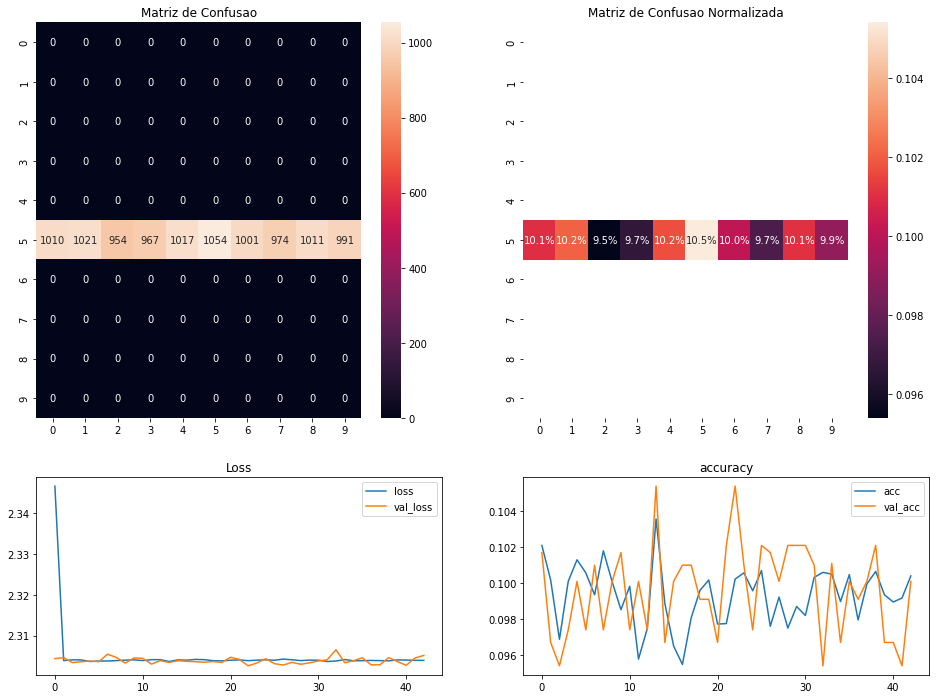

In [32]:
print_evaluate(model_conv_p_01,history_model_conv_p_01, x_val, y_val_f, 'model_conv_p_01.h5')

A rede não conseguiu sair de um mínimo local, provavelmente devido a quantidade de parâmetros, o que pode melhorar é deixar a rede mais simples

4.2 - Segunda CNN

Teste de filtro em cima de filtro, diminuindo a quantidade de parâmetros




In [33]:
model_ff = Sequential()

# 1- set
# CONV 
model_ff.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
model_ff.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# POOLING LAYER
model_ff.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
# CONV 
model_ff.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# POOLING LAYER
model_ff.add(MaxPool2D(pool_size=(2, 2)))

model_ff.add(Flatten())
# 3- FC
model_ff.add(Dense(256, activation='relu'))

model_ff.add(Dense(10, activation='sigmoid'))


model_ff.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_ff.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [34]:
filepath="model_ff.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_ff= model_ff.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 5s 3ms/step - loss: 2.3275 - accuracy: 0.0973 - val_loss: 2.3035 - val_accuracy: 0.1001

Epoch 00001: val_accuracy improved from -inf to 0.10010, saving model to model_ff.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3040 - accuracy: 0.1023 - val_loss: 2.3039 - val_accuracy: 0.1011

Epoch 00002: val_accuracy improved from 0.10010 to 0.10110, saving model to model_ff.h5
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3040 - accuracy: 0.1001 - val_loss: 2.3038 - val_accuracy: 0.1001

Epoch 00003: val_accuracy did not improve from 0.10110
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3039 - accuracy: 0.1005 - val_loss: 2.3039 - val_accuracy: 0.0954

Epoch 00004: val_accuracy did not improve from 0.10110
Epoch 5/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3041 - accuracy: 0.0970 - val_loss: 2.3037 - val_accuracy: 


Fazendo Predicoes da Validacao



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()




Acurácia balanceada: nan 



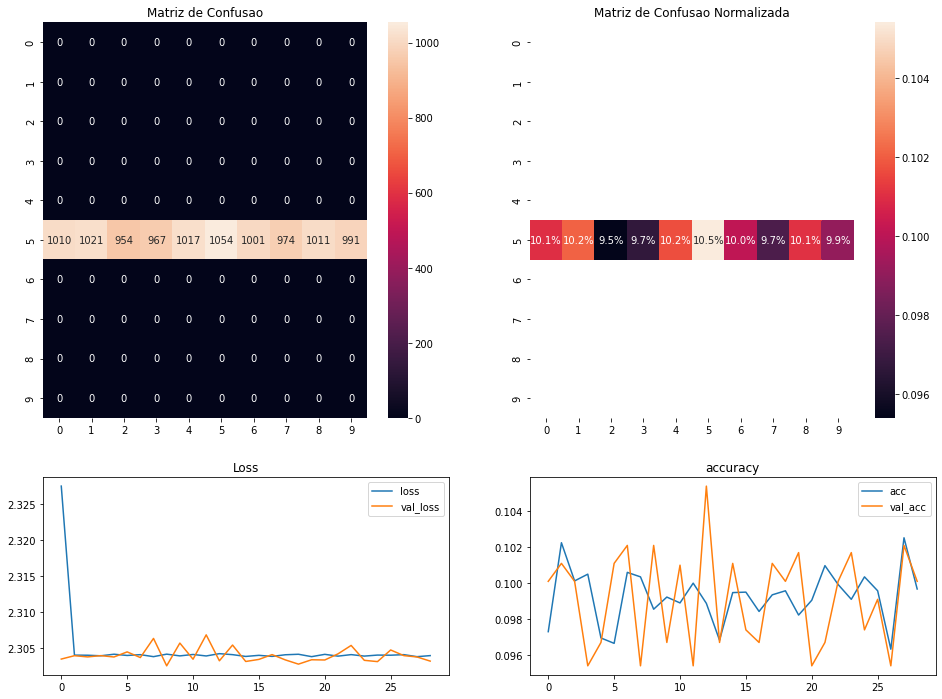

In [35]:
print_evaluate(model_ff,history_model_ff, x_val, y_val_f, 'model_ff.h5')

Esse estudo sem variação de inicialização , dropout e outros induz a produzir redes mais simples , a rede treinada tem o viés de cair sempre em algum mínimo local

# 5) Explorando Inicializações e regularizações (1,5)
'glorot_normal' vs 'random_normal'

#### 5.1 - glorot_normal
Teste com rede com menor quantidade de parametros

In [36]:
model_ff_r_01 = Sequential()

# 1- set
# CONV 
model_ff_r_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',kernel_initializer='glorot_normal'))
model_ff_r_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# POOLING LAYER
model_ff_r_01.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
# CONV 
model_ff_r_01.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# POOLING LAYER
model_ff_r_01.add(MaxPool2D(pool_size=(2, 2)))

model_ff_r_01.add(Flatten())
# 3- FC
model_ff_r_01.add(Dense(256, activation='relu'))

model_ff_r_01.add(Dense(10, activation='sigmoid'))


model_ff_r_01.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_ff_r_01.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [37]:
filepath="model_ff_r_01.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_ff_r_01= model_ff_r_01.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 5s 3ms/step - loss: 2.3201 - accuracy: 0.1001 - val_loss: 2.3037 - val_accuracy: 0.0974

Epoch 00001: val_accuracy improved from -inf to 0.09740, saving model to model_ff_r_01.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3185 - accuracy: 0.1003 - val_loss: 2.3034 - val_accuracy: 0.1010

Epoch 00002: val_accuracy improved from 0.09740 to 0.10100, saving model to model_ff_r_01.h5
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3040 - accuracy: 0.1013 - val_loss: 2.3033 - val_accuracy: 0.1017

Epoch 00003: val_accuracy improved from 0.10100 to 0.10170, saving model to model_ff_r_01.h5
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3040 - accuracy: 0.0976 - val_loss: 2.3034 - val_accuracy: 0.1054

Epoch 00004: val_accuracy improved from 0.10170 to 0.10540, saving model to model_ff_r_01.h5
Epoch 5/64
1250/1250 [=============================


Fazendo Predicoes da Validacao



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()




Acurácia balanceada: nan 



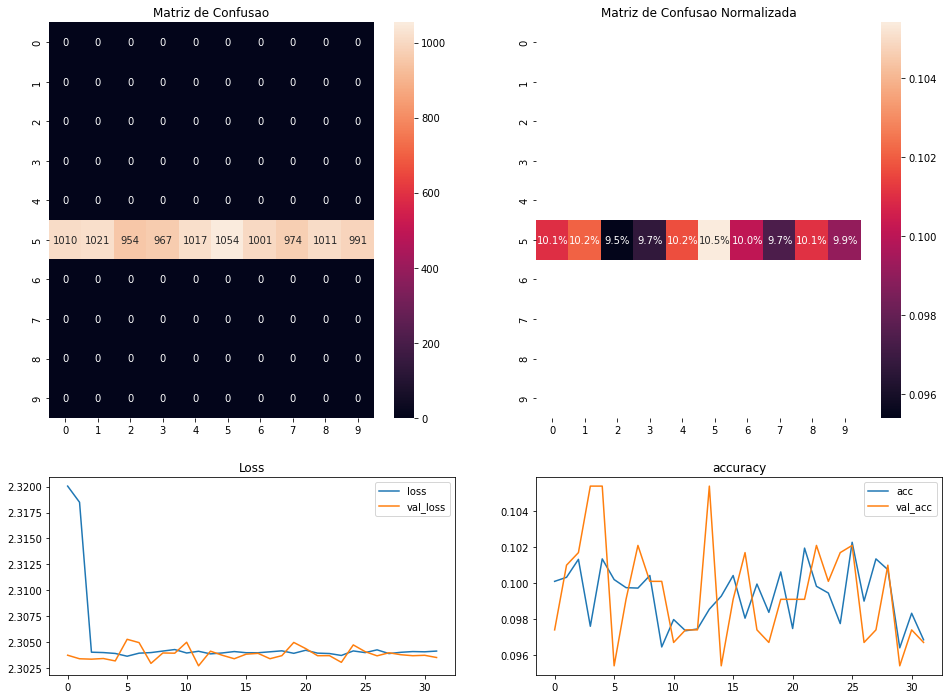

In [38]:
print_evaluate(model_ff_r_01,history_model_ff_r_01, x_val, y_val_f, 'model_ff_r_01.h5')

com a inicialização kernel_initializer='glorot_normal' , a rede fica em um minimo local, não tem variáveis para tirar ela de lá, na teoria sem os dropouts algo que  poderia melhora é deixar o modelo mais simples

### 5.2 - random_normal

In [39]:

model_ff_r_02 = Sequential()

# 1- set
# CONV 
model_ff_r_02.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',kernel_initializer='random_normal'))
model_ff_r_02.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# POOLING LAYER
model_ff_r_02.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
# CONV 
model_ff_r_02.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# POOLING LAYER
model_ff_r_02.add(MaxPool2D(pool_size=(2, 2)))

model_ff_r_02.add(Flatten())
# 3- FC
model_ff_r_02.add(Dense(256, activation='relu'))

model_ff_r_02.add(Dense(10, activation='sigmoid'))


model_ff_r_02.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])





model_ff_r_02.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)              

In [40]:
filepath="model_ff_r_02.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_ff_r_02= model_ff_r_02.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 5s 3ms/step - loss: 2.3090 - accuracy: 0.0993 - val_loss: 2.3042 - val_accuracy: 0.1054

Epoch 00001: val_accuracy improved from -inf to 0.10540, saving model to model_ff_r_02.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3041 - accuracy: 0.1006 - val_loss: 2.3037 - val_accuracy: 0.1017

Epoch 00002: val_accuracy did not improve from 0.10540
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3042 - accuracy: 0.0999 - val_loss: 2.3050 - val_accuracy: 0.0974

Epoch 00003: val_accuracy did not improve from 0.10540
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3039 - accuracy: 0.0997 - val_loss: 2.3042 - val_accuracy: 0.1011

Epoch 00004: val_accuracy did not improve from 0.10540
Epoch 5/64
1250/1250 [==============================] - 4s 3ms/step - loss: 2.3039 - accuracy: 0.1007 - val_loss: 2.3045 - val_accuracy: 0.1011

Epoch 00005: val_acc


Fazendo Predicoes da Validacao



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()




Acurácia balanceada: nan 



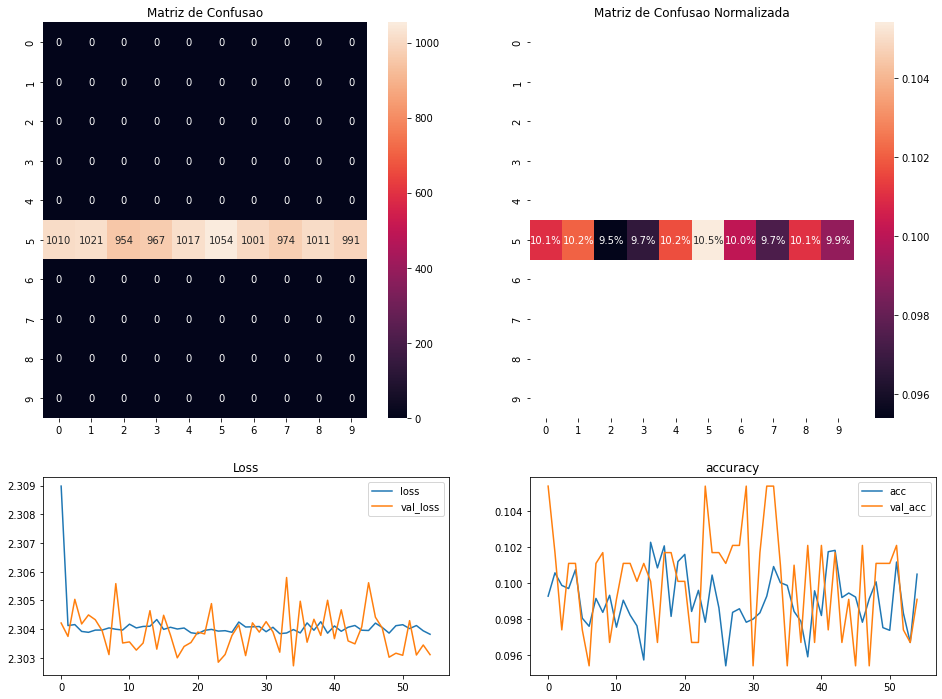

In [41]:
print_evaluate(model_ff_r_02,history_model_ff_r_02, x_val, y_val_f, 'model_ff_r_02.h5')

### 5.3 - testes com Baseline
devido a complexidade alta e o modelo não estar conseguindo se ajustar, vamos testar com modelos mais simples variando a inicialização e regularizão


#### 5.3.1 - Baseline - inicialização glorot_normal

In [42]:
# Rede Neural Vanilla

model_baseline_r_gn = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline_r_gn.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal'))
#Max pooling de tamanho 2x2
model_baseline_r_gn.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_r_gn.add(Flatten())
#Densa com 10 nós de saída
model_baseline_r_gn.add(Dense(10 ,activation = 'softmax'))

model_baseline_r_gn.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline_r_gn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [43]:
filepath="model_baseline_r_gn.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_r_gn= model_baseline_r_gn.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9134 - accuracy: 0.3234 - val_loss: 1.8072 - val_accuracy: 0.3439

Epoch 00001: val_accuracy improved from -inf to 0.34390, saving model to model_baseline_r_gn.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8034 - accuracy: 0.3604 - val_loss: 1.8164 - val_accuracy: 0.3554

Epoch 00002: val_accuracy improved from 0.34390 to 0.35540, saving model to model_baseline_r_gn.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7880 - accuracy: 0.3680 - val_loss: 1.7752 - val_accuracy: 0.3671

Epoch 00003: val_accuracy improved from 0.35540 to 0.36710, saving model to model_baseline_r_gn.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7705 - accuracy: 0.3740 - val_loss: 1.8905 - val_accuracy: 0.3151

Epoch 00004: val_accuracy did not improve from 0.36710
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - l


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.38105068127003905 



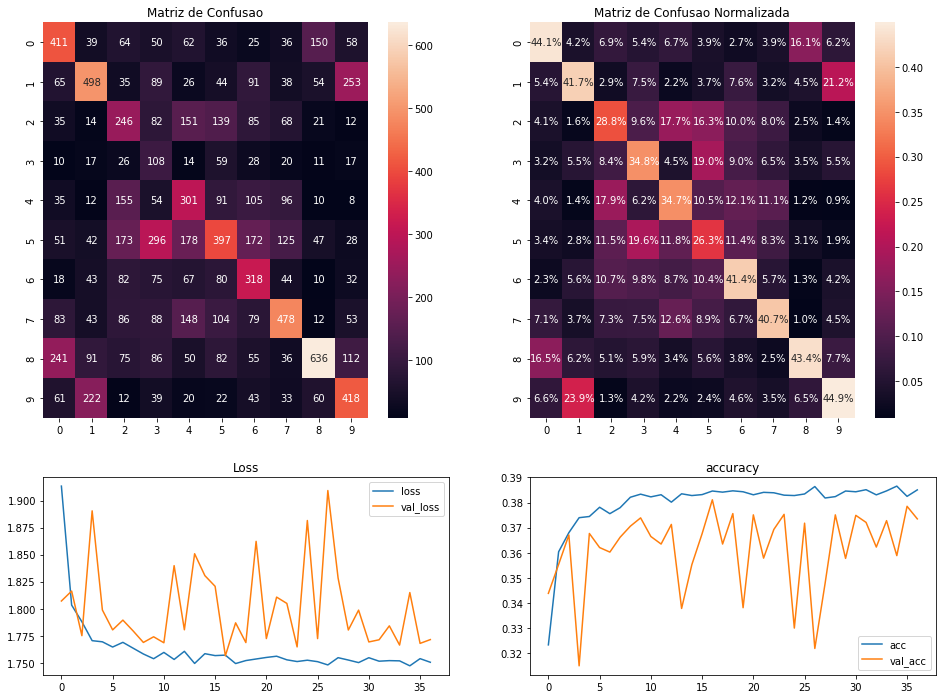

In [44]:
print_evaluate(model_baseline_r_gn,history_model_baseline_r_gn, x_val, y_val_f, 'model_baseline_r_gn.h5')

#### 5.3.2 - Baseline - inicialização random_normal

In [45]:
# Rede Neural Vanilla

model_baseline_r_rn = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline_r_rn.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='random_normal'))
#Max pooling de tamanho 2x2
model_baseline_r_rn.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_r_rn.add(Flatten())
#Densa com 10 nós de saída
model_baseline_r_rn.add(Dense(10 ,activation = 'softmax'))

model_baseline_r_rn.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline_r_rn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [46]:
filepath="model_baseline_r_rn.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_r_rn= model_baseline_r_rn.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9325 - accuracy: 0.3052 - val_loss: 1.7881 - val_accuracy: 0.3600

Epoch 00001: val_accuracy improved from -inf to 0.36000, saving model to model_baseline_r_rn.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7935 - accuracy: 0.3559 - val_loss: 1.8481 - val_accuracy: 0.3502

Epoch 00002: val_accuracy did not improve from 0.36000
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7780 - accuracy: 0.3626 - val_loss: 1.8085 - val_accuracy: 0.3585

Epoch 00003: val_accuracy did not improve from 0.36000
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7737 - accuracy: 0.3650 - val_loss: 1.8097 - val_accuracy: 0.3430

Epoch 00004: val_accuracy did not improve from 0.36000
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7666 - accuracy: 0.3668 - val_loss: 1.7714 - val_accuracy: 0.3578

Epoch 00005: v


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.3856809562166497 



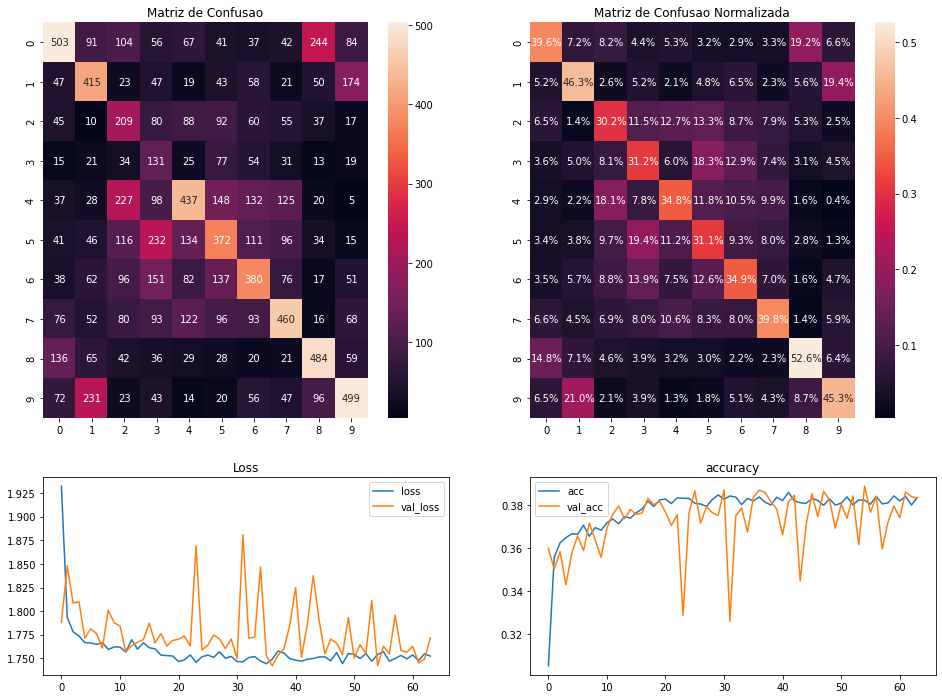

In [47]:
print_evaluate(model_baseline_r_rn,history_model_baseline_r_rn, x_val, y_val_f, 'model_baseline_r_rn.h5')

parece um viés de confirmação, porém a inicialização glorot_normal apresentou melhores resultados , vamos explorar agora um pouco as regularizações e funções de normalização

#### 5.3.2 - Baseline - inicialização glorot_normal com regularização e normalização


In [48]:
# Rede Neural Vanilla

model_baseline_r_gn_n = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline_r_gn_n.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_baseline_r_gn_n.add(BatchNormalization())

#Max pooling de tamanho 2x2
model_baseline_r_gn_n.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_r_gn_n.add(Flatten())
#Densa com 10 nós de saída
model_baseline_r_gn_n.add(Dense(10 ,activation = 'softmax'))

model_baseline_r_gn_n.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline_r_gn_n.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                81930     
Total params: 82,954
Trainable params: 82,890
Non-trainable params: 64
_________________________________________________________________


In [49]:
filepath="model_baseline_r_gn_n.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_r_gn_n= model_baseline_r_gn_n.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9593 - accuracy: 0.4296 - val_loss: 1.9990 - val_accuracy: 0.3756

Epoch 00001: val_accuracy improved from -inf to 0.37560, saving model to model_baseline_r_gn_n.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4808 - accuracy: 0.5062 - val_loss: 1.6114 - val_accuracy: 0.4811

Epoch 00002: val_accuracy improved from 0.37560 to 0.48110, saving model to model_baseline_r_gn_n.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4528 - accuracy: 0.5224 - val_loss: 1.5219 - val_accuracy: 0.5139

Epoch 00003: val_accuracy improved from 0.48110 to 0.51390, saving model to model_baseline_r_gn_n.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4342 - accuracy: 0.5315 - val_loss: 1.5817 - val_accuracy: 0.4837

Epoch 00004: val_accuracy did not improve from 0.51390
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/st


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5543384807208438 



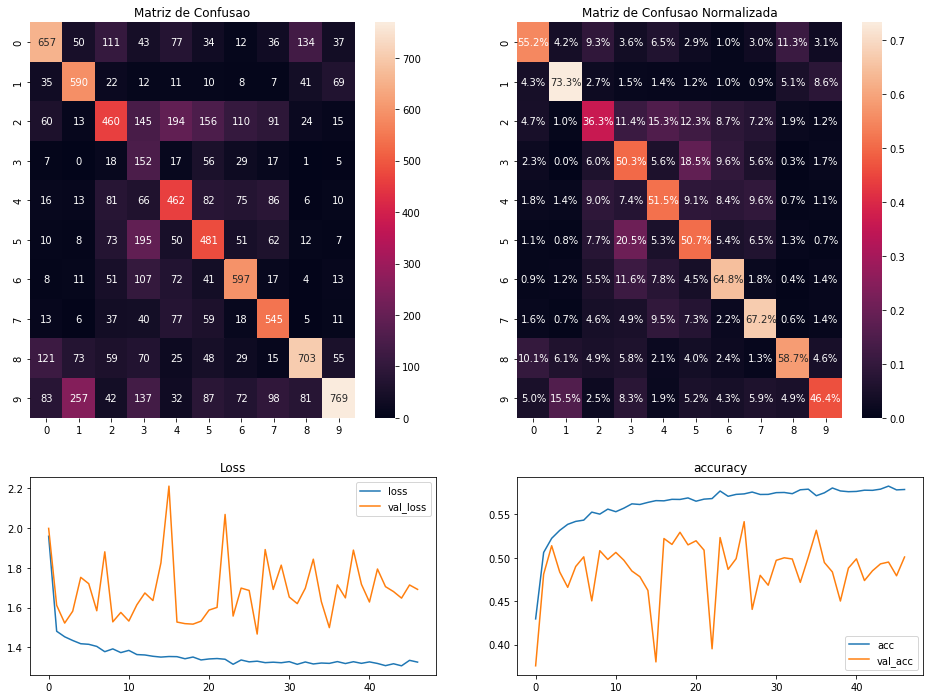

In [50]:
print_evaluate(model_baseline_r_gn_n,history_model_baseline_r_gn_n, x_val, y_val_f, 'model_baseline_r_gn_n.h5')

Com regularização e normalização a rede alcançou acurácias maiores mais rapido *


# 6. Avalie o Uso de Dropout

####  6.1 - teste com uma rede um pouco mais robusta
Validando se com dropout a rede consegue sair dos mínimos locais

In [51]:
model_skw_01 = Sequential()

# 1- set
# CONV 
model_skw_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# NORM
model_skw_01.add(BatchNormalization())
# CONV 
model_skw_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same', activation='relu',))
# NORM
model_skw_01.add(BatchNormalization())
# POOLING LAYER
model_skw_01.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
model_skw_01.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same', activation='relu',))
# NORM
model_skw_01.add(BatchNormalization())
# POOLING LAYER
model_skw_01.add(MaxPool2D(pool_size=(2, 2)))

model_skw_01.add(Flatten())
#sem sentido esse dropout
model_skw_01.add(Dropout(0.2))

model_skw_01.add(Dense(1024, activation='relu'))

model_skw_01.add(Dropout(0.2))

model_skw_01.add(Dense(10, activation='sigmoid'))


model_skw_01.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_skw_01.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)      

De 81k foi para 4,2kk parâmetros

In [52]:
filepath="model_skw_01.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_skw_01= model_skw_01.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 6s 4ms/step - loss: 2.5697 - accuracy: 0.2799 - val_loss: 1.9837 - val_accuracy: 0.3283

Epoch 00001: val_accuracy improved from -inf to 0.32830, saving model to model_skw_01.h5
Epoch 2/64
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5425 - accuracy: 0.4448 - val_loss: 1.4409 - val_accuracy: 0.4998

Epoch 00002: val_accuracy improved from 0.32830 to 0.49980, saving model to model_skw_01.h5
Epoch 3/64
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3509 - accuracy: 0.5364 - val_loss: 1.5029 - val_accuracy: 0.5195

Epoch 00003: val_accuracy improved from 0.49980 to 0.51950, saving model to model_skw_01.h5
Epoch 4/64
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2638 - accuracy: 0.5719 - val_loss: 1.2401 - val_accuracy: 0.5872

Epoch 00004: val_accuracy improved from 0.51950 to 0.58720, saving model to model_skw_01.h5
Epoch 5/64
1250/1250 [==============================] -


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.6989446205640524 



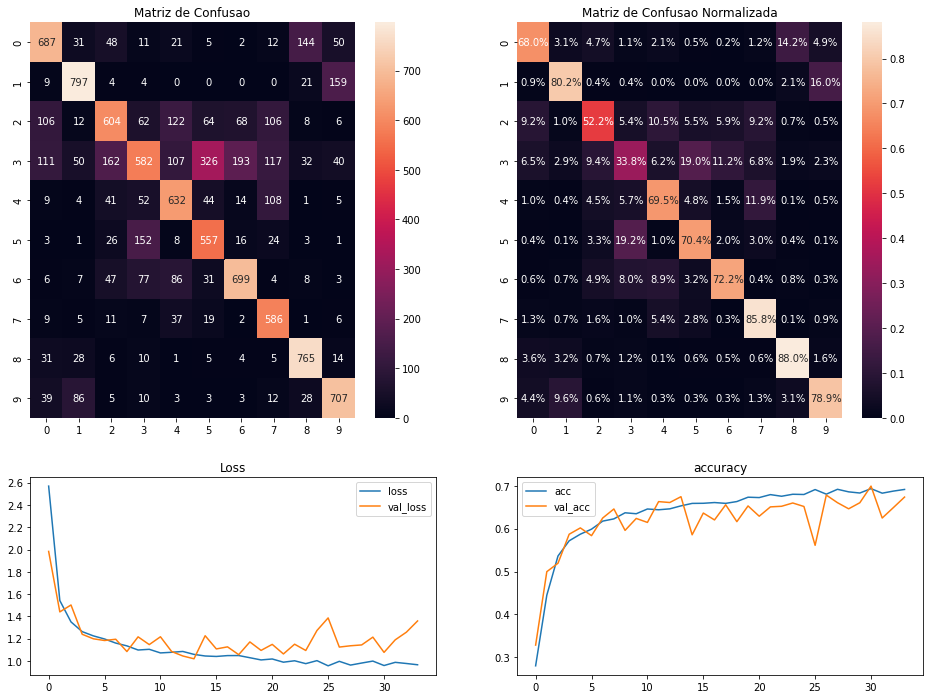

In [53]:
print_evaluate(model_skw_01,history_model_skw_01, x_val, y_val_f, 'model_skw_01.h5')

Com o Dropout a rede consegue sair de mínimos locais, vamos almentar as camadas de complexidade para verificar a evolução, pelos gráficos de loss e accuray a rede ainda não apresentou nas epochs regiões de overfitting

####  6.2 - teste com uma rede com mais camadas complexas
Validando se conseguimos melhorar a acuracia da rede

In [54]:
model_skw_02 = Sequential()


# 1- set
# CONV 
model_skw_02.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# CONV 
model_skw_02.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# POOLING LAYER
model_skw_02.add(MaxPool2D(pool_size=(2, 2)))


# 2- set
model_skw_02.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# CONV 
model_skw_02.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# POOLING LAYER
model_skw_02.add(MaxPool2D(pool_size=(2, 2)))

# 3 - set

model_skw_02.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# CONV 
model_skw_02.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# POOLING LAYER
model_skw_02.add(MaxPool2D(pool_size=(2, 2)))


# 4- FC
model_skw_02.add(Flatten())
#sem sentido esse dropout
model_skw_02.add(Dropout(0.2))
# DENSE 01
model_skw_02.add(Dense(1024, activation='relu'))

model_skw_02.add(Dropout(0.2))
# DENSE 02
model_skw_02.add(Dense(10, activation='sigmoid'))


model_skw_02.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_skw_02.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 32)      

In [55]:
filepath="model_skw_02.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=40)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_skw_02= model_skw_02.fit(x_train, y_train_f,
                               epochs = 128, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/128
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4522 - accuracy: 0.2836 - val_loss: 2.4045 - val_accuracy: 0.3008

Epoch 00001: val_accuracy improved from -inf to 0.30080, saving model to model_skw_02.h5
Epoch 2/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5963 - accuracy: 0.4213 - val_loss: 1.7433 - val_accuracy: 0.5275

Epoch 00002: val_accuracy improved from 0.30080 to 0.52750, saving model to model_skw_02.h5
Epoch 3/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.2989 - accuracy: 0.5465 - val_loss: 2.6374 - val_accuracy: 0.6003

Epoch 00003: val_accuracy improved from 0.52750 to 0.60030, saving model to model_skw_02.h5
Epoch 4/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1681 - accuracy: 0.6013 - val_loss: 1.3464 - val_accuracy: 0.5664

Epoch 00004: val_accuracy did not improve from 0.60030
Epoch 5/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0782 - ac


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.7388833926443652 



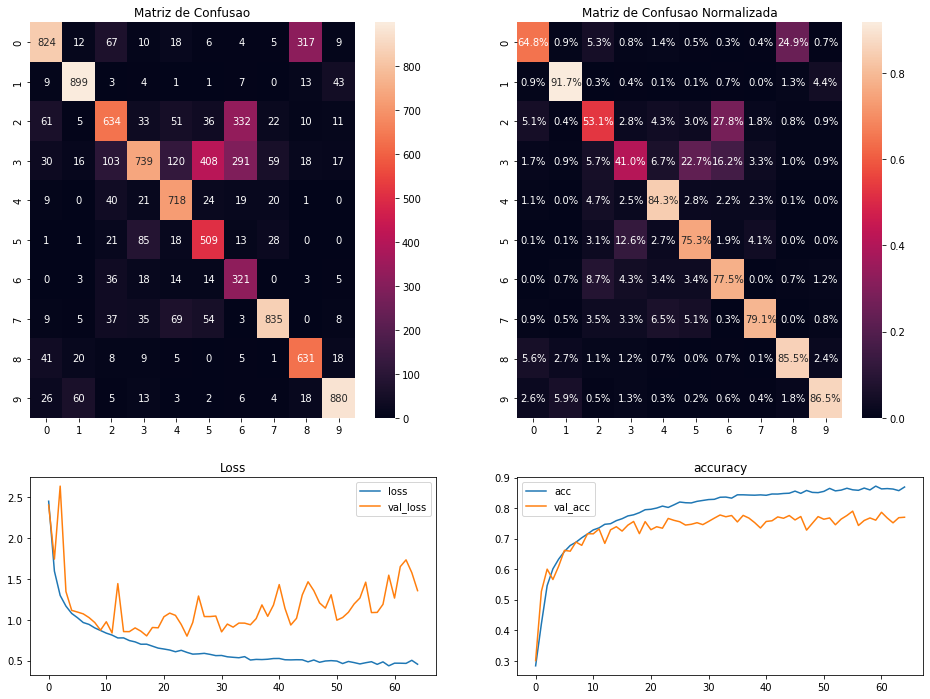

In [56]:
print_evaluate(model_skw_02,history_model_skw_02, x_val, y_val_f, 'model_skw_02.h5')

####  6.3 - teste com uma rede com mais camadas complexas
Validando se conseguimos melhorar a acuracia da rede com aumento da complexidade dos dados de entrada

In [62]:
model_skw_03 = Sequential()


# 1- set
# CONV 
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 2- set
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))

# 3 - set

model_skw_03.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 4- FC
model_skw_03.add(Flatten())
#sem sentido esse dropout
model_skw_03.add(Dropout(0.2))
# DENSE 01
model_skw_03.add(Dense(1024, activation='relu'))

model_skw_03.add(Dropout(0.2))
# DENSE 02
model_skw_03.add(Dense(10, activation='softmax'))


model_skw_03.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_skw_03.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_22 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 16, 32)      

In [63]:
filepath="model_skw_03.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=40)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train_f, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size



history_model_skw_03= model_skw_03.fit(train_generator,steps_per_epoch=steps_per_epoch,
                                                    epochs = 128, batch_size = batch_size,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint]  )


Epoch 1/128
1250/1250 [==============================] - 19s 14ms/step - loss: 2.6022 - accuracy: 0.2579 - val_loss: 1.9053 - val_accuracy: 0.2940

Epoch 00001: val_accuracy improved from -inf to 0.29400, saving model to model_skw_03.h5
Epoch 2/128
1250/1250 [==============================] - 18s 14ms/step - loss: 1.7749 - accuracy: 0.3496 - val_loss: 2.7589 - val_accuracy: 0.3872

Epoch 00002: val_accuracy improved from 0.29400 to 0.38720, saving model to model_skw_03.h5
Epoch 3/128
1250/1250 [==============================] - 18s 14ms/step - loss: 1.5709 - accuracy: 0.4299 - val_loss: 1.4192 - val_accuracy: 0.4980

Epoch 00003: val_accuracy improved from 0.38720 to 0.49800, saving model to model_skw_03.h5
Epoch 4/128
1250/1250 [==============================] - 18s 14ms/step - loss: 1.4423 - accuracy: 0.4879 - val_loss: 1.6724 - val_accuracy: 0.4915

Epoch 00004: val_accuracy did not improve from 0.49800
Epoch 5/128
1250/1250 [==============================] - 18s 14ms/step - loss: 1


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.8331544060610602 



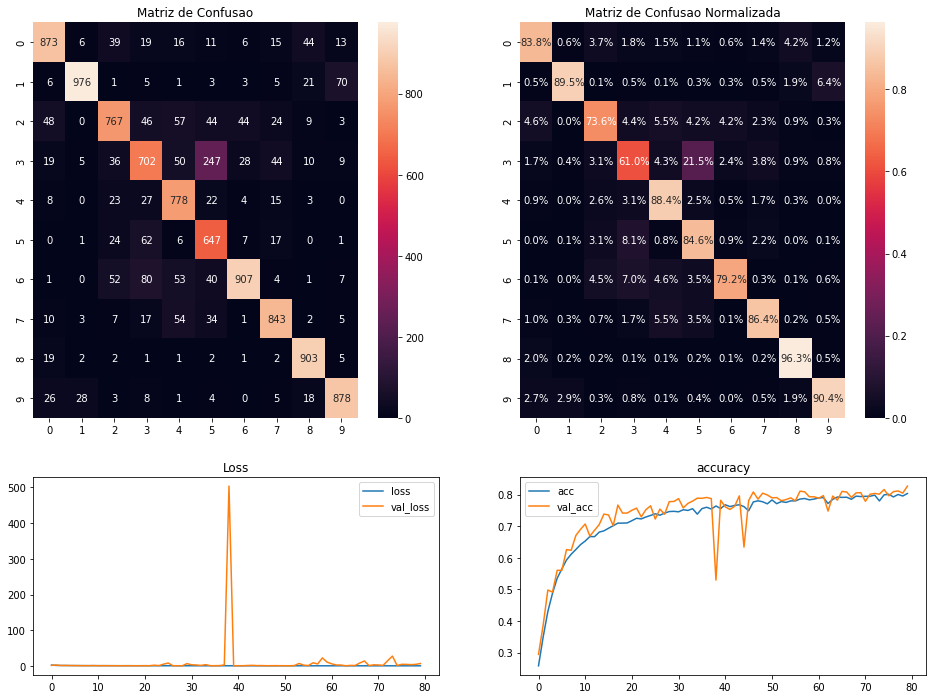

In [64]:
print_evaluate(model_skw_03,history_model_skw_03, x_val, y_val_f, 'model_skw_03.h5')

# 7) Plote os gráficos da função de loss×número de épocas, para o treino e validação de cada modelo. Houve overfitting?


Já foi feito, explicar um pouco dos exemplos ...


# 8. (0,5) A partir dos experimentos acima, construa o que você considera o melhor modelo e faça a avaliação no conjunto de teste. 
Obs: Avaliação no conjunto de teste só pode ser executada uma única vez.

In [ ]:
def print_evaluate(model, model_history , x_val, y_val_model, model_filepath):
    print("\nFazendo Predicoes da Validacao\n")
    model.load_weights(model_filepath)
    predictions = model.predict(x_val)
    #score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.
    
    #Matriz de confusão
    cm = confusion_matrix(np.argmax(predictions, axis=1), y_val)


    cm_b = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
    balanced_acc = np.trace(cm_b) / num_classes
    print("\n\nAcurácia balanceada:", balanced_acc, "\n")

    fig, axs = plt.subplots(2, 2, figsize = (16,12), gridspec_kw={'height_ratios': [2, 1]})

    #ax[0,0]
    sns.heatmap(ax = axs[0, 0], data = cm, fmt='g', annot = True)
    axs[0, 0].set_title('Matriz de Confusao')
    #ax[0,1]
    sns.heatmap(ax = axs[0, 1], data =cm_b, fmt='.1%', annot = True)
    axs[0, 1].set_title('Matriz de Confusao Normalizada')

    #ax[1,0]
    axs[1, 0].set_title('Loss')
    axs[1, 0].plot(model_history.history['loss'], label='loss')
    axs[1, 0].plot(model_history.history['val_loss'], label='val_loss')
    axs[1, 0].legend()

    axs[1, 1].set_title('accuracy')
    axs[1, 1].plot(model_history.history['accuracy'], label='acc')
    axs[1, 1].plot(model_history.history['val_accuracy'], label='val_acc')
    axs[1, 1].legend()  


In [66]:
model_skw_03.load_weights('model_skw_03.h5')
predictions = model_skw_03.predict(x_test)


In [70]:
cm = confusion_matrix(np.argmax(predictions, axis=1), y_test_f)


cm_b = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cm_b) / num_classes
print("\n\nAcurácia balanceada:", balanced_acc, "\n")



Acurácia balanceada: 0.8277981515267714 



In [75]:
df_history = pd.DataFrame(history_model_skw_03.history)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


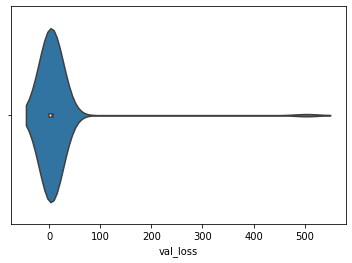

In [81]:
sns.violinplot(df_history['val_loss'])

In [90]:
pd.qcut(df_history['val_loss'], 4).unique().sort_values()


[(0.721, 0.962], (0.962, 1.4], (1.4, 3.588], (3.588, 503.688]]
Categories (4, interval[float64]): [(0.721, 0.962] < (0.962, 1.4] < (1.4, 3.588] < (3.588, 503.688]]

In [ ]:
    fig, axs = plt.subplots(2, 2, figsize = (16,12), gridspec_kw={'height_ratios': [2, 1]})

    #ax[0,0]
    sns.heatmap(ax = axs[0, 0], data = cm, fmt='g', annot = True)
    axs[0, 0].set_title('Matriz de Confusao')
    #ax[0,1]
    sns.heatmap(ax = axs[0, 1], data =cm_b, fmt='.1%', annot = True)
    axs[0, 1].set_title('Matriz de Confusao Normalizada')

    #ax[1,0]
    axs[1, 0].set_title('Loss')
    axs[1, 0].plot(model_history.history['loss'], label='loss')
    axs[1, 0].plot(model_history.history['val_loss'], label='val_loss')
    axs[1, 0].legend()

    axs[1, 1].set_title('accuracy')
    axs[1, 1].plot(model_history.history['accuracy'], label='acc')
    axs[1, 1].plot(model_history.history['val_accuracy'], label='val_acc')
    axs[1, 1].legend()  


# 9. (2,0) Sumarize os seus resultados e conclusões em relação aos resultados experimentais.